## Two-level system optimization

We consider the canonical Landau-Zener model with
$$\hat{H}_n = \hat{H}_d + \hat{H}_c=\frac{1}{2}\left(\hat{\sigma}_x+u_n\cdot\hat{\sigma}_z\right)$$
and the state transfer
\begin{equation*}
\ket{\psi_{\mathrm{ini}}}\equiv\ket{\uparrow}\longrightarrow\ket{\psi_{\mathrm{tgt}}}\equiv\ket{\downarrow}\quad.
\end{equation*}
Employing the "natural" basis $\{\ket{\uparrow}, \ket{\downarrow}\}$, this problem is already represented in the necessary control-diagonal form.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.style.use('science')
from mpl2latex import mpl2latex, latex_figsize
mpl2latex()

import numpy as np
from numpy.linalg import norm
from numpy import array, ndarray
from scipy.linalg import expm
from scipy.optimize import fmin_l_bfgs_b
from tqdm.notebook import trange

In [2]:
colorr = '#FF2C00'
colorb = '#0C5DA5'
colorg = '#00B945'
msize = 3

### Initialization

In [3]:
# defines input parameters:
#   - Nt: nr of time steps & nr of time-evolving unitary operators
#   - N: nr of elements in the wave functions
#   - T: time window in units of pi
#   - controls are N (Nt) for the trapezoidal (rectangular) rule

def input_parameters(Nt: int, T: int):
    N = Nt + 1
    delta_t = T / Nt

    print('# time steps:\t', Nt)
    print('time step:\t', delta_t)

    return N, delta_t

In [4]:
N, delta_t = input_parameters(Nt=50, T=1)

N_trap = N
N_rect = N - 1

# time steps:	 50
time step:	 0.02


In [5]:
# initial and target states

psi_ini = array([1,0])
psi_tgt = array([0,1])

dim = 1         # global dimension
d = 2           # local dimension
D_H = d**dim    # Hilbert space dimension

In [6]:
# row-major ordering: first index is the one of the nr of iterations, allowing for faster access when updating the control vector

def initialize_controls_register(n: int, n_iter: int, u_start: ndarray or None = None):
    # J = len(H_ops) to add list of control operators
    J = 1
    # u = (iterations × nr of controls × nr of time steps)
    u = np.zeros((n_iter, J, n))
    if u_start is not None:
        for idx, u0 in enumerate(u_start):
            u[0, idx, :] = u0
    return u

def initialize_controls(n: int, u_start: ndarray or None = None):
    J = 1
    # u = (nr of controls × nr of time steps)
    u = np.zeros((J, n))
    if u_start is not None:
        for idx, u0 in enumerate(u_start):
            u[idx, :] = u0
    return u

### Integration rules, time evolution and gradient

Updates are in the form
\begin{align*}
&\mathbf{u}^{(k+1)}=\mathbf{u}^{(k)}+\alpha^{(k)}\mathbf{p}^{(k)}
&\alpha^{(k)}\in\mathbb{R}^+
\end{align*}

\begin{equation*}
J(\mathbf{u}^{(k+1)})\leq J(\mathbf{u}^{(k)})\quad.
\end{equation*}

We concentrate here on the implementation of the **gradient**. The goal is to replicate the target unitary transformation up to a global phase. We implement a class to efficiently evaluate the cost function $J_F$ and the gradient: as input, it accepts one vector of controls of length $N$.

Remembering that the final states are obtained by stepwise evolution according to
\begin{align*}
\ket{\psi_{n+1}}&=\hat{U}_n\ket{\psi_n}\\
\ket{\chi_{n}}&=\hat{U}^\dagger_n\ket{\chi_{n+1}}\quad,
\end{align*}
the time evolution can be generalized as
\begin{equation*}
\frac{\partial F}{\partial u_j} = 2 \mathrm{Re} \left( o^* \cdot\sum_{n=1}^N \bra{\chi_{N-n}} \frac{\partial U_n}{\partial u_j} \ket{\psi_{n-1}} \right)\quad ,
\end{equation*}
with the derivative of the time-evolution operator being evaluable — if not analytically available like in this case — via, e.g., automatic differentiation. This is usually non-zero only for a few $n$'s per each $j$ - e.g. in the trapezoidal scheme, there are two such terms.

In [7]:
class trapezoid:

    def __init__(self, ctrl):
        self.ctrl = ctrl                                                                # controls
        self.N = len(self.ctrl)                                                         # nr of evolutions = nr controls = Nt + 1 = N
        self.dim = D_H                                                                  # Hilbert space dimension
        self.delta_t = delta_t * np.pi                                                  # pi re-scaled time step
        self.evolved_psi, self.evolved_chi = self.time_evolution()                      # evoluted wave functions
        self.overlap = np.dot(np.conj(self.evolved_chi[-1]), self.evolved_psi[-1])      # overlap
        self.coverlap = np.conj(self.overlap)                                           # conjugated overlap
        
    def time_evolution(self):

        evolved_psi = np.zeros((self.N, self.dim), dtype=complex)                       # psi evolution vector
        evolved_chi = np.zeros((self.N, self.dim), dtype=complex)                       # chi evolution vector
        trotter = np.zeros((self.N-1, 2, self.dim), dtype=complex)                      # trotterized operators

        Hd = 1/2 * array([[0, 1], [1, 0]])                                              # drift Hamiltonian is computed once
        b = expm(-1j * Hd * self.delta_t)

        evolved_psi[0] = psi_ini                                                        # initialize evolutions
        evolved_chi[-1] = psi_tgt

        for n in range(1, self.N):                                                      # iterate over the control vector
            Hc_next = 1/2 * self.ctrl[n] * array([1, -1])                               # store diagonals only
            Hc_curr = 1/2 * self.ctrl[n-1] * array([1, -1])
            a = np.exp(-1j * Hc_next * self.delta_t / 2)
            c = np.exp(-1j * Hc_curr * self.delta_t / 2)
            
            trotter[n-1] = a, c                                                         # save operator
            evolve_psi = lambda x: a * np.dot(b, c * x)                                 # build trotterized propagator
            evolved_psi[n] = evolve_psi(evolved_psi[n-1])                               # evolve psi
            evolved_psi[n] = evolved_psi[n] / norm(evolved_psi[n])                      # impose normalization

        for n in range(self.N-1, 0, -1):
            a, c = trotter[n-1]
            evolve_chi = lambda x: np.conj(c) * np.dot(np.conj(b.T), np.conj(a) * x)    # build trotterized propagator
            evolved_chi[n-1] = evolve_chi(evolved_chi[n])                               # evolve chi
            evolved_chi[n-1] = evolved_chi[n-1] / norm(evolved_chi[n-1])                # impose normalization

        return evolved_psi, evolved_chi

    def F(self):
        return np.real(self.overlap * self.coverlap)

    def gradient(self):
        dHdun = 1/2 * array([1, -1])
        sandwich = array([np.dot(np.conj(self.evolved_chi[n]), dHdun * self.evolved_psi[n]) for n in range(self.N)])
        sandwich[0] = 1/2 * sandwich[0]
        sandwich[-1] = 1/2 * sandwich[-1]
        return np.real(1j * self.coverlap * sandwich) * self.delta_t

In [8]:
class rectangle:

    def __init__(self, ctrl):
        self.ctrl = ctrl                                                                # controls
        self.N = len(self.ctrl) + 1                                                     # nr of evolutions = nr of controls + 1 = Nt + 1 = N
        self.dim = D_H                                                                  # Hilbert space dimension
        self.delta_t = delta_t * np.pi                                                  # pi re-scaled time step
        self.evolved_psi, self.evolved_chi = self.time_evolution()                      # evoluted wave functions
        self.overlap = np.dot(np.conj(self.evolved_chi[-1]), self.evolved_psi[-1])      # overlap
        self.coverlap = np.conj(self.overlap)                                           # conjugated overlap
        
    def time_evolution(self):

        evolved_psi = np.zeros((self.N, self.dim), dtype=complex)                       # psi evolution vector
        evolved_chi = np.zeros((self.N, self.dim), dtype=complex)                       # chi evolution vector
        trotter = np.zeros((self.N-1, self.dim), dtype=complex)                         # trotterized operators

        Hd = 1/2 * array([[0, 1], [1, 0]])                                              # drift Hamiltonian is computed once
        b = expm(-1j * Hd * self.delta_t)

        evolved_psi[0] = psi_ini                                                        # initialize evolutions
        evolved_chi[-1] = psi_tgt

        for n in range(1, self.N):                                                      # iterate over the control vector
            H_c = 1/2 * self.ctrl[n-1] * array([1, -1])                                 # store diagonals only
            a = np.exp(-1j * H_c * self.delta_t / 2)
            
            trotter[n-1] = a                                                            # save operators
            evolve_psi = lambda x: a * np.dot(b, a * x)                                 # build trotterized propagator
            evolved_psi[n] = evolve_psi(evolved_psi[n-1])                               # evolve psi
            evolved_psi[n] = evolved_psi[n] / norm(evolved_psi[n])                      # impose normalization

        for n in range(self.N-1, 0, -1):
            a = np.conj(trotter[n-1])
            evolve_chi = lambda x: a * np.dot(np.conj(b.T), a * x)                      # build trotterized propagator
            evolved_chi[n-1] = evolve_chi(evolved_chi[n])                               # evolve chi
            evolved_chi[n-1] = evolved_chi[n-1] / norm(evolved_chi[n-1])                # impose normalization

        return evolved_psi, evolved_chi

    def F(self):
        return np.real(self.overlap * self.coverlap)

    def gradient(self):
        dHdun = 1/2 * array([1, -1])
        sandwich = array([np.dot(np.conj(self.evolved_chi[n]), dHdun * self.evolved_psi[n]) for n in range(self.N)])
        neighbor_sum = array([sandwich[n+1] + sandwich[n] for n in range(self.N-1)])
        return np.real(1j * self.coverlap * 1/2 * neighbor_sum) * self.delta_t

In [9]:
# apply known solution

control_start = np.zeros(N_trap)
trap = trapezoid(control_start)

print('initial state:\t', trap.evolved_psi[0])
print('final state:\t', trap.evolved_psi[-1])
print('\nFinal fidelity:')
print('F = ', trap.F())

initial state:	 [1.+0.j 0.+0.j]
final state:	 [-3.24046345e-15+0.j  0.00000000e+00-1.j]

Final fidelity:
F =  1.0


In [10]:
# apply known solution

control_start = np.zeros(N_rect)
rect = rectangle(control_start)

print('initial state:\t', rect.evolved_psi[0])
print('final state:\t', rect.evolved_psi[-1])
print('\nFinal fidelity:')
print('F = ', rect.F())

initial state:	 [1.+0.j 0.+0.j]
final state:	 [-3.24046345e-15+0.j  0.00000000e+00-1.j]

Final fidelity:
F =  1.0


In [11]:
rect.evolved_psi

array([[ 1.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [ 9.99506560e-01+0.j        ,  0.00000000e+00-0.03141076j],
       [ 9.98026728e-01+0.j        ,  0.00000000e+00-0.06279052j],
       [ 9.95561965e-01+0.j        ,  0.00000000e+00-0.09410831j],
       [ 9.92114701e-01+0.j        ,  0.00000000e+00-0.12533323j],
       [ 9.87688341e-01+0.j        ,  0.00000000e+00-0.15643447j],
       [ 9.82287251e-01+0.j        ,  0.00000000e+00-0.18738131j],
       [ 9.75916762e-01+0.j        ,  0.00000000e+00-0.21814324j],
       [ 9.68583161e-01+0.j        ,  0.00000000e+00-0.24868989j],
       [ 9.60293686e-01+0.j        ,  0.00000000e+00-0.27899111j],
       [ 9.51056516e-01+0.j        ,  0.00000000e+00-0.30901699j],
       [ 9.40880769e-01+0.j        ,  0.00000000e+00-0.33873792j],
       [ 9.29776486e-01+0.j        ,  0.00000000e+00-0.36812455j],
       [ 9.17754626e-01+0.j        ,  0.00000000e+00-0.39714789j],
       [ 9.04827052e-01+0.j        ,  0.00000000e+00-0.4257792

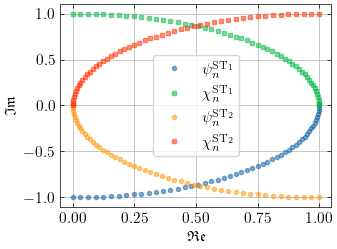

In [12]:
plt.plot(trap.evolved_psi.real.T[0], trap.evolved_psi.imag.T[1], 'o', alpha=.5, label='$\psi^{\mathrm{ST_1}}_n$', markersize=msize)
plt.plot(trap.evolved_chi.real.T[1], trap.evolved_chi.imag.T[0], 's', alpha=.5, label='$\chi^{\mathrm{ST_1}}_n$', markersize=msize)
plt.plot(1-rect.evolved_psi.real.T[0], rect.evolved_psi.imag.T[1], 'o', alpha=.5, label='$\psi^{\mathrm{ST_2}}_n$', markersize=msize)
plt.plot(1-rect.evolved_chi.real.T[1], rect.evolved_chi.imag.T[0], 's', alpha=.5, label='$\chi^{\mathrm{ST_2}}_n$', markersize=msize)
plt.ylabel('$\mathfrak{Im}$')
plt.xlabel('$\mathfrak{Re}$')
plt.legend(frameon=True)
plt.minorticks_off()
plt.grid(True)
plt.savefig('plots/lz_ev.pdf')
plt.show()

$\langle\psi_j\ket{\chi_j}=c\in\mathbb{R}\ \forall j\in [1,\dots,N]$, since $\langle\psi_j\ket{\chi_j}=\bra{\psi_1}U^\dagger_1 U^\dagger_2\dots U^\dagger_{j-1} U^\dagger_{j}\dots U^\dagger_{N-1} U^\dagger_{N-1}\ket{\chi_N}=\langle\psi_1\ket{\chi_1}$

For the correct time evolution, $c=1$.

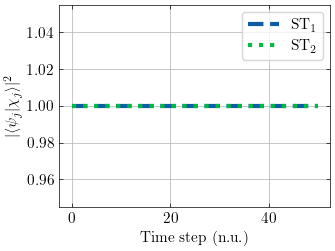

In [13]:
check_trap = [np.dot(np.conj(trap.evolved_psi[j]), trap.evolved_chi[j]) for j in range(N)]
check_trap = [np.real(c * np.conj(c)) for c in check_trap]
check_rect = [np.dot(np.conj(rect.evolved_psi[j]), rect.evolved_chi[j]) for j in range(N)]
check_rect = [np.real(c * np.conj(c)) for c in check_rect]

plt.plot(check_trap, linestyle='dashed', label='$\mathrm{ST}_1$', linewidth=3)
plt.plot(check_rect, linestyle='dotted', label='$\mathrm{ST}_2$', linewidth=3)
plt.xlabel('Time step $(\mathrm{n.u.})$')
plt.ylabel('$|\\langle\psi_j|\chi_j\\rangle|^2$')
plt.grid(True)
plt.legend(frameon=True)
plt.minorticks_off()
plt.savefig('plots/lz_abs.pdf')
plt.show()

In the **trapezoidal** setting, the first and last element of the gradient are zero; in fact
\begin{align*}
\frac{\partial F}{\partial u_j}&=\delta_t(2-\delta_{j,0}-\delta_{j,N})\cdot\mathrm{Im}\left[\langle\psi_j\ket{\chi_j}\left\langle\chi_j\left|\frac{\partial H_c(t_j)}{\partial u_j}\right|{\psi_j}\right\rangle\right]\\&=\delta_t(2-\delta_{j,0}-\delta_{j,N})\cdot\mathrm{Im}\left[\mathrm{Tr}\left(\ket{\chi_j}\left\langle\chi_j\left|\frac{\partial H_c(t_j)}{\partial u_j}\right|{\psi_j}\right\rangle\bra{\psi_j}\right)\right]
\\&=\delta_t(2-\delta_{j,0}-\delta_{j,N})\cdot\mathrm{Im}\left[\mathrm{Tr}\left(\rho^{(\chi)}_j\frac{\partial H_c(t_j)}{\partial u_j}\rho^{(\psi)}_j\right)\right]\\&\overset{\text{(a)}}{=}\frac{\delta}{4}(2-\delta_{j,0}-\delta_{j,N})\sin(\theta^{(\chi)}_j)\sin(\theta^{(\psi)}_j)\sin(\varphi^{(\chi)}_j-\varphi^{(\psi)}_j)\quad ,
\end{align*}
where in (a) we used
\begin{align*}
\frac{\partial H_c(t_j)}{\partial u_j}&=\frac{1}{2}\hat{\sigma}_z\\
\rho&=\frac{1}{2}(\text{I}+\vec{r}\cdot\vec{\hat{\sigma}})
\end{align*}
Thus, whenever one of two points is at the pole of the Bloch sphere $\frac{\partial F}{\partial u_j}=0$. This is exactly what happens for $j=0$, $j=N$ with the conditions
\begin{align*}
\ket{\psi_{\mathrm{ini}}}\equiv\ket{\psi_0}&=\ket{\uparrow}\\
\ket{\psi_{\mathrm{tgt}}}\equiv\ket{\chi_0}&=\ket{\downarrow}\quad.
\end{align*}
This also shows that the gradient can indicate $0$ in a lot of cases where the overlap is not maximal. Indeed, the fidelity in terms of the same parametrization reads:
\begin{equation*}
F=\frac{1}{2} \left(1+\cos(\theta^{(\chi)})\cos(\theta^{(\psi)})+\sin(\theta^{(\chi)})\sin(\theta^{(\psi)})\cos(\varphi^{(\chi)}-\varphi^{(\psi)})\right)\quad .
\end{equation*}
If one would use the full time-evolution operator on the interval $\hat{U}^{\mathrm{Ex}_1}_n$ - for which one needs automatic differentiation or so to compute the derivative - the gradient would not be zero at the poles.

Finally, we usually do not want to compute the time-evolution operators (and their derivatives) explicitly, but rather only their action on an arbitrary vector — i.e., we want to define a function $U(t_n,\vec{u}, \ket{\phi})$ that evolves $\ket{\phi}$ of a time-step $\delta$ according to the dynamics at time $t_n$. The formula then becomes:
\begin{equation*}
\frac{\partial F}{\partial u_j} = 2 \mathrm{Re} \left( o^* \cdot\sum_{n=1}^N \bra{\chi_{N-n}} \frac{\partial U(t_n, \vec{u}, \ket{\psi_{n-1}})}{\partial u_j} \right)\quad.
\end{equation*}

### Optimal control

#### Steepest descent: perturbation of initial solution

We perturbe the initial controls to see if a simple gradient descent rule brings them back to the analytical solution. Noise is $\in\mathcal{N}(0,1)$.

In [14]:
N, delta_t = input_parameters(Nt=50, T=1.01)

N_trap = N
N_rect = N - 1

# time steps:	 50
time step:	 0.0202


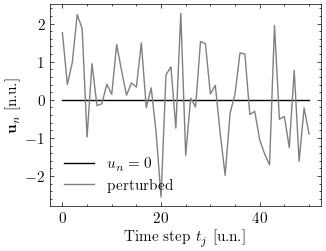

In [15]:
np.random.seed(0)
u_n = np.zeros(N_trap)
noise = np.random.normal(0, 1, N_trap)
pcontrol_start = u_n + noise

plt.plot(u_n, color='k', label='$u_n=0$')
plt.plot(pcontrol_start, color='gray', label='perturbed')
plt.xlabel('Time step $t_j$ [$\mathrm{u.n.}$]')
plt.ylabel('$\mathbf{u}_n$ [$\mathrm{n.u.}$]') # which unit?
plt.legend()
plt.show()

In [16]:
iterations = 20

lr = 10
decay_rate = 0.96
decay_steps = 10

controls_trap = initialize_controls_register(N_trap, iterations, u_start=[pcontrol_start])
controls_rect = initialize_controls_register(N_rect, iterations, u_start=[pcontrol_start[:-1]])
fidelities_trap = np.zeros(iterations-1)
fidelities_rect = np.zeros(iterations-1)

In [17]:
for k in trange(iterations-1):
    # define trapezoid/rectangle object
    u_trap = controls_trap[k, :, :][0]
    u_rect = controls_rect[k, :, :][0]
    trap = trapezoid(u_trap)
    rect = rectangle(u_rect)
    # compute fidelities
    fidelities_trap[k] = trap.F()
    fidelities_rect[k] = rect.F()
    # set alpha
    alpha = lr * decay_rate ** (k / decay_steps)
    # update control tensor
    controls_trap[k+1, :, :][0] = u_trap - alpha * trap.gradient()
    controls_rect[k+1, :, :][0] = u_rect - alpha * rect.gradient()

  0%|          | 0/19 [00:00<?, ?it/s]

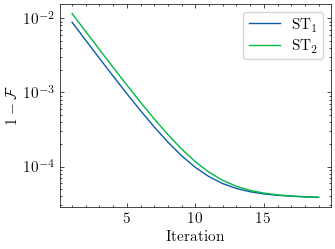

In [18]:
x = np.arange(1, iterations)
plt.plot(x, 1-fidelities_trap, label='$\mathrm{ST}_1$')
plt.plot(x, 1-fidelities_rect, label='$\mathrm{ST}_2$')
plt.axhline(y=0, color='gray', linestyle='dotted')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$1-\mathcal{F}$')
plt.legend(frameon=True)
plt.show()

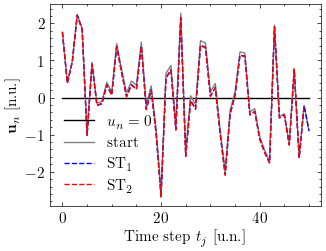

In [19]:
plt.plot(u_n, color='k', label='$u_n=0$')
plt.plot(pcontrol_start, color='gray', label='start')
plt.plot(controls_trap[-1, :, :][0], color='b', linestyle='dashed', label='$\mathrm{ST}_1$')
plt.plot(controls_rect[-1, :, :][0], color='r', linestyle='dashed', label='$\mathrm{ST}_2$')
plt.xlabel('Time step $t_j$ [$\mathrm{u.n.}$]')
plt.ylabel('$\mathbf{u}_n$ [$\mathrm{n.u.}$]')
plt.legend()
plt.show()

#### Jensen's paper: steepest descent

In [20]:
iterations = 80

lr = 20
decay_rate = 0.96
decay_steps = 30

np.random.seed(0)
rcontrol_start = np.random.uniform(-10, 10, N_trap)

controls_trap = initialize_controls_register(N_trap, iterations, u_start=[rcontrol_start])
controls_rect = initialize_controls_register(N_rect, iterations, u_start=[rcontrol_start[:-1]])
fidelities_trap = np.zeros(iterations-1)
fidelities_rect = np.zeros(iterations-1)

In [21]:
for k in trange(iterations-1):
    # define trapezoid/rectangle object
    u_trap = controls_trap[k, :, :][0]
    u_rect = controls_rect[k, :, :][0]
    trap = trapezoid(u_trap)
    rect = rectangle(u_rect)
    # compute fidelities
    fidelities_trap[k] = trap.F()
    fidelities_rect[k] = rect.F()
    # set alpha
    alpha = lr * decay_rate ** (k / decay_steps)
    # update control tensor
    controls_trap[k+1, :, :][0] = u_trap - alpha * trap.gradient()
    controls_rect[k+1, :, :][0] = u_rect - alpha * rect.gradient()

  0%|          | 0/79 [00:00<?, ?it/s]

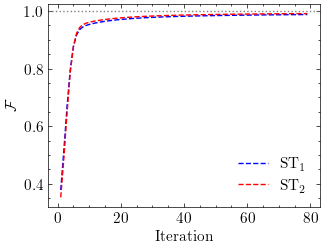

In [22]:
x = np.arange(1, iterations)
plt.plot(x, fidelities_trap, color='b', linestyle='dashed', label='$\mathrm{ST}_1$')
plt.plot(x, fidelities_rect, color='r', linestyle='dashed', label='$\mathrm{ST}_2$')
plt.axhline(y=1, color='gray', linestyle='dotted')
plt.xlabel('Iteration')
plt.ylabel('$\mathcal{F}$')
plt.legend()
plt.show()

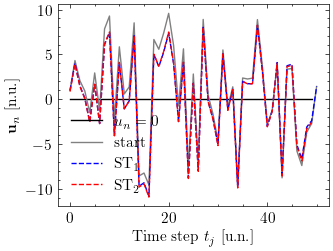

In [23]:
plt.plot(control_start, color='k', label='$u_n=0$')
plt.plot(rcontrol_start, color='gray', label='start')
plt.plot(controls_trap[-1, :, :][0], color='b', linestyle='dashed', label='$\mathrm{ST}_1$')
plt.plot(controls_rect[-1, :, :][0], color='r', linestyle='dashed', label='$\mathrm{ST}_2$')
plt.xlabel('Time step $t_j$ [$\mathrm{u.n.}$]')
plt.ylabel('$\mathbf{u}_n$ [$\mathrm{n.u.}$]')
plt.legend()
plt.show()

#### Jensen's paper: L-BFGS-B search algorithm

In [24]:
def JF_trap_bfgs(u):
    F = trapezoid(u).F()
    return 1/2 * (1 - F)

def gradient_trap_bfgs(u):
    return trapezoid(u).gradient()

def JF_rect_bfgs(u):
    F = rectangle(u).F()
    return 1/2 * (1 - F)

def gradient_rect_bfgs(u):
    return rectangle(u).gradient()

In [25]:
bound = 10
bounds = [(-bound, bound) for _ in range(len(control_start)+1)]

In [26]:
x_trap, f, d = fmin_l_bfgs_b(func=JF_trap_bfgs, x0=rcontrol_start, fprime=gradient_trap_bfgs, bounds=bounds, m=17, factr=10.0, maxfun=900)
print('Trapezoid rule:')
print(' - simulation converged:\t', d['warnflag']==0)
print(' - number of iterations:\t', d['nit'])
print(' - final fidelity:\t', 1-2*f)

x_rect, f, d = fmin_l_bfgs_b(func=JF_rect_bfgs, x0=rcontrol_start[:-1], fprime=gradient_rect_bfgs, bounds=bounds[:-1], m=17, factr=10.0, maxfun=900)
print('\nRectangular rule:')
print(' - simulation converged:\t', d['warnflag']==0)
print(' - number of iterations:\t', d['nit'])
print(' - final fidelity:\t', 1-2*f)

Trapezoid rule:
 - simulation converged:	 True
 - number of iterations:	 18
 - final fidelity:	 0.9999697077809283

Rectangular rule:
 - simulation converged:	 True
 - number of iterations:	 14
 - final fidelity:	 0.9999594286325519


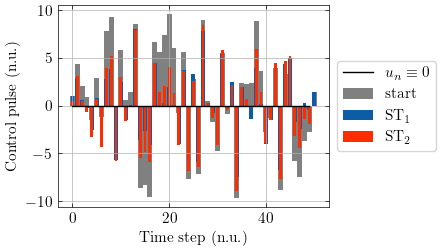

In [27]:
x = range(len(control_start)+1)
plt.plot(control_start, color='k', label='$u_n\equiv 0$')
plt.bar(x, rcontrol_start, width=1, color='gray', label='start')
plt.bar(x, x_trap, color=colorb, width=0.8, label='$\mathrm{ST}_1$')
plt.bar(x[:-1], x_rect, color=colorr, width=0.6, label='$\mathrm{ST}_2$')
plt.xlabel('Time step $(\mathrm{n.u.})$')
plt.ylabel('Control pulse $(\mathrm{n.u.})$')
plt.legend(frameon=True, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.minorticks_off()
plt.savefig('plots/lz_ctrls.pdf')
plt.show()